# Initialize NMRlipids databank

In [62]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Databank/Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

def CalcAreaPerMolecule(system):
    APLpath = system['path'] + 'apl.json'
    try:
        f = open(APLpath)
        APLdata = json.load(f)
        sumAPL = 0
        sumIND = 0
        for i,j in APLdata.items():
            sumAPL += j
            sumIND += 1
        APL = sumAPL/sumIND
        return(APL)
    except:
        print('apl.json not found from' + system['path'])
        
def GetThickness(system):
    ThicknessPath = system['path'] + 'thickness.json'
    try:
        f = open(ThicknessPath)
        thickness = json.load(f)
        return(thickness)
    except:
        pass
        #print('thickness.json not found from' + system['path'])
    
    
def GetFormFactorMin(system):
    FormFactorPath = system['path'] + 'FormFactor.json'
    #try:
    f = open(FormFactorPath)
    FormFactor = json.load(f)
    FFarray = np.array(FormFactor)
    #print(FFarray)
    result = np.where(arr2D == np.amin(FFarray,axis=0))
    print(np.amin(FFarray,axis=0))
    #mymin = min([min(r[1]) for r in FormFactor])
    #print(mymin)
    #except:
    #    pass

# Create area per lipid data of mixtures containing MATRIX or ADDITIVE lipids, or both

mkdir: cannot create directory ‘./results/POPS_in_POPC/’: File exists
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./results/POPS_in_POPC/T303.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat -o ./results/POPS_in_POPC/T303.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat'
apl.json not found from../../Databank/Data/Simulations/8d8/5c6/8d85c662a53e14e285a3bcfb75c55f3fef35be4b/343a5f2b56bf580ab0e4fb5d444c2c947c825dd3/
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./results/POPS_in_POPC/T310.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat -o ./results/POPS_in_POPC/T310.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat'
sort: cannot read: ./results/POPS_in_POPC/T320.0K_CHAR

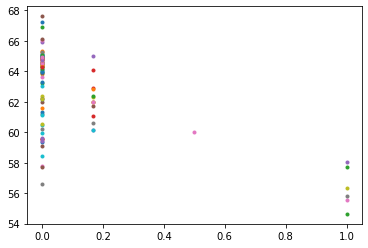

In [10]:
MATRIX = 'POPC'
ADDITIVE = 'POPS'

ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
!mkdir {ResultDir}
!rm {ResultDir}/*

apl_DICT = {}
for system in systems:
    
    try:
        NADDITIVE = np.sum(system['COMPOSITION'][ADDITIVE]['COUNT'])
    except:
        NADDITIVE = 0    
    
    try:
        NMATRIX = np.sum(system['COMPOSITION'][MATRIX]['COUNT'])
    except:
        NMATRIX = 0
    
    NLIPIDS = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NLIPIDS += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    if (NMATRIX + NADDITIVE) != NLIPIDS:
        #print('skipped')
        continue
    
    
    APL = CalcAreaPerMolecule(system)
    if not APL:
        continue
    
    plt.plot(NADDITIVE / NLIPIDS, APL,'.')
    
    try:
        CaConcentration = system['COMPOSITION']['CAL']['COUNT'] * 55.5 / system['COMPOSITION']['SOL']['COUNT']
    except:
        CaConcentration = 0
    lipidsRATIO = 100*NADDITIVE / NLIPIDS
    forcefield = system.get('FF')
    temperature = system.get('TEMPERATURE')
    DOI = system.get('DOI')
    apl_DICT[lipidsRATIO,CaConcentration,forcefield,temperature,DOI] = APL
   
    OutFileName = ResultDir + 'T' + str(temperature) + 'K'

    try:
        NSOD = np.sum(system['COMPOSITION']['SOD']['COUNT'])
    except:
        NSOD = 0    
        
    try:
        NCLA = np.sum(system['COMPOSITION']['CLA']['COUNT'])
    except:
        NCLA = 0    
    
    if NCLA > 0 and not 'DHMDMAB' in ADDITIVE:
        #print('skipped')
        continue
        
    if ('POPG' in ADDITIVE or 'POPS' in ADDITIVE) and NADDITIVE != NSOD:
        #print('skipped')
        continue
    
    try:
        OutFileName = OutFileName + '_' + system['FF'] +'.dat'
    except:
        continue
    #print(OutFileName)
    
    outfile=open(OutFileName,'a')
    outfile.write(str(round(lipidsRATIO,3)) + " " + str(APL) + " " + str(system['DOI']))
    outfile.write('\n')
    outfile.close()
    !sort -n -k 1 {OutFileName} -o {OutFileName}

# Plot area per lipid data of MATRIX and ADDITIVE mixtures 

Text(0, 0.5, 'Area per molecule (nm)^2')

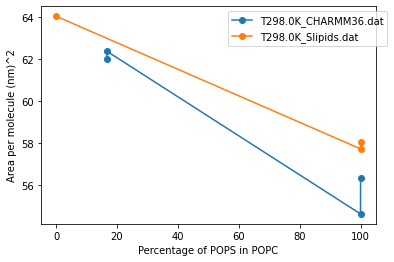

In [11]:
for subdir, dirs, files in os.walk(ResultDir):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".dat"):
            with open(filepath) as APLfile:
                lines = APLfile.readlines()#[1:]
                x = [float(line.split()[0]) for line in lines]
                y = [float(line.split()[1]) for line in lines]
                #print(filepath,x,y)
                if len(set(x)) > 1:
                    plt.plot(x,y,label = filename,marker='o')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
plt.ylabel('Area per molecule (nm)^2')
#plt.savefig('../Figs/aplTST.png', bbox_inches='tight')

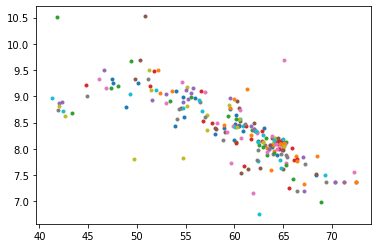

In [45]:
APL = []
Thickness = []
for system in systems:
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if APLvalue and ThicknessValue:
        plt.plot(APLvalue,ThicknessValue,'.')
    
    #    APL.append(APLvalue)
    #    Thickness.append(ThicknessValue)
    #APLvsThickness.append([APL,thickness])
#plt.plot(APL,Thickness)

In [63]:
for system in systems:
    GetFormFactorMin(system)

[0.         0.02080384]
[0.         0.00690989]
[0.         0.07195513]
[0.         0.24137319]
[0.         0.02113083]
[0.         0.01196657]
[0.         0.02286513]
[0.        0.0593916]
[0.        0.0510754]
[0.         0.02768796]
[0.         0.00146886]
[0.         0.03443324]
[0.         0.02615082]
[0.         0.04860769]
[0.         0.01766696]
[0.         0.09975101]
[0.         0.01768156]
[0.         0.13088756]
[0.         0.02966544]
[0.        0.0150559]
[0.         0.03204618]
[0.         0.02262617]
[0.         0.03180194]
[0.         0.01577612]
[0.         0.01880889]
[0.         0.00359024]
[0.         0.05830585]


FileNotFoundError: [Errno 2] No such file or directory: '../../Databank/Data/Simulations/7f6/fbc/7f6fbc9ec469b1d33d2ec93cccdd86768443988f/f7a6d748844cb56fec39dd0c2f27b9483a291114/FormFactor.json'

In [43]:
for system in systems:
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if ThicknessValue and ThicknessValue < 4:
        print(system)

{'FF_DATE': '?/?/2020', 'TYPEOFSYSTEM': 'lipid bilayer', 'SYSTEM': 'POPC:POPG(4:1)_T298K_1MCaCl', 'TEMPERATURE': 298.0, 'NUMBER_OF_ATOMS': 134109, 'EXPERIMENT': {'POPG': {}, 'POPC': {}}, 'FF_SOURCE': 'NMRlipidsIV', 'COMPOSITION': {'POPG': {'NAME': 'PGR', 'COUNT': [44, 44], 'MAPPING': 'mappingPOPGlipid17ecc.txt'}, 'CLA': {'NAME': 'CL', 'COUNT': 950, 'MAPPING': 'mappingCLAecc.txt'}, 'CAL': {'NAME': 'CA', 'COUNT': 475, 'MAPPING': 'mappingCALecc.txt'}, 'SOD': {'NAME': 'NA', 'COUNT': 88, 'MAPPING': 'mappingSODecc.txt'}, 'POPC': {'NAME': 'PC', 'COUNT': [175, 175], 'MAPPING': 'mappingPOPClipid17ecc.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 24840, 'MAPPING': 'mappingSPCwater.txt'}}, 'TIMELEFTOUT': 0, 'TRJLENGTH': 300020.0, 'DATEOFRUNNING': '04/10/2021', 'FF': 'lipid17ecc', 'SOFTWARE': 'gromacs', 'PREEQTIME': 100, 'DOI': '10.5281/zenodo.3997184', 'TRAJECTORY_SIZE': 7486025608, 'TPR': [['run_400ns.tpr']], 'TRJ': [['100-400ns.xtc']], 'DIR_WRK': '/media/osollila/Data/tmp/DATABANK/', 'path': '../../Da

In [41]:
ThicknessValue